In [1]:
import os
import keyring

OPENAI_API_KEY = keyring.get_password('openai', 'key_for_windows')
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

### Libraries

In [2]:
from typing import List, Annotated, Literal
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage, ToolMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from pydantic import BaseModel

In [ ]:
# define a function to collect information for prompting

temaplate = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from there:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the ouput MUST adhere to

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool."""

def get_message_info(messages):
    return [SystemMessage(content=temaplate)] + messages    # llm 역할을 계속해서 기억하도록 messages를 붙여줌

class PromptInstructions(BaseModel):
    """Instructions on how to promnpt the LLM."""
    
    objective: str 
    variables: List[str]
    constraints: List[str]
    requirements: List[str]
    
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
llm_with_tool = llm.bind_tools([PromptInstructions])

def info_chain(state):
    messages = get_message_info(state['messages'])
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [13]:
# prompt function
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

# new system prompt
prompt_system = """Based on the following requirements, write a good prompt template:

{reqs}"""

# function to get the message for the prompt
# will only get messages AFTER the tool call

def get_prompt_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]['args']
            print(tool_call)
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs

def prompt_gen_chain(state):
    messages = get_prompt_messages(state['messages'])
    response = llm.invoke(messages)
    return {'messages': [response]}

In [5]:
# edge logic for getting information to construct prompts
from typing import Literal
from langgraph.graph import END

def get_state(state) -> Literal['prompt', 'info', '__end__']:
    messages = state['messages']
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return 'prompt'
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return 'info'

In [9]:
# build a graph
class State(TypedDict):
    messages: Annotated[list, add_messages]
    
memory = MemorySaver()
workflow = StateGraph(State)

# add nodes
workflow.add_node('info', info_chain)
workflow.add_node('prompt', prompt_gen_chain)

# add edges and conditional edges
workflow.add_conditional_edges("info", get_state)
workflow.add_edge('prompt', END)
workflow.add_edge(START, "info")

# compile the graph
graph = workflow.compile(checkpointer=memory)

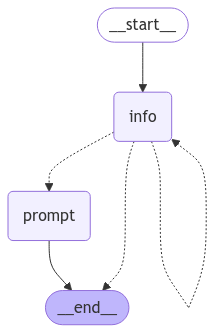

In [10]:
# plot the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
# run the graph
import uuid

config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True: 
    user = input("User (q\Q to quit): ")
    if user in {'q', 'Q'}:
        print("AI: Byebye")
        break
    output = None
    for output in graph.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, stream_mode='updates'
    ):
        last_message = next(iter(output.values()))['messages'][-1]
        last_message.pretty_print()
    
    if output and 'prompt' in output:
        print("Done!")

================================== Ai Message ==================================

시를 작성하는 프롬프트를 만들기 위해 몇 가지 정보를 더 필요로 합니다. 다음 질문에 답해 주실 수 있나요?

1. 시의 목적은 무엇인가요? (예: 감정 표현, 특정 주제에 대한 탐구 등)
2. 프롬프트 템플릿에 어떤 변수를 포함하고 싶으신가요? (예: 주제, 스타일, 길이 등)
3. 출력에서 피해야 할 제약 조건이 있나요? (예: 특정 단어 사용 금지, 특정 형식 준수 등)
4. 출력이 반드시 따라야 할 요구 사항이 있나요? (예: 특정 형식, 특정 감정 표현 등)

이 정보를 제공해 주시면, 적절한 프롬프트 템플릿을 생성할 수 있습니다.
================================== Ai Message ==================================

감정 표현을 위한 겨울 주제의 시를 작성하는 프롬프트를 만들기 위해 추가적인 정보가 필요합니다. 다음 질문에 답해 주실 수 있나요?

1. 프롬프트 템플릿에 포함하고 싶은 변수가 있나요? (예: 시의 길이, 특정 감정 등)
2. 출력에서 피해야 할 제약 조건이 있나요? (예: 특정 단어 사용 금지, 특정 형식 준수 등)
3. 출력이 반드시 따라야 할 요구 사항이 있나요? (예: 특정 형식, 특정 감정 표현 등)

이 정보를 제공해 주시면, 적절한 프롬프트 템플릿을 생성할 수 있습니다.
================================== Ai Message ==================================

감정 표현을 위한 겨울 주제의 시를 작성하는 프롬프트에 대한 정보는 다음과 같습니다:

- **목적**: 감정 표현
- **주제**: 겨울
- **변수**: 시의 길이 (4문단), 이해 난이도 (초등학생도 이해할 수 있는 정도)
- **제약 조건**: 특정 단어 사용 금지 (없음으로 가정)
- **요구 사항**